['/Users/khador/Documents', '/usr/local/Cellar/python@3.9/3.9.0_2/Frameworks/Python.framework/Versions/3.9/lib/python39.zip', '/usr/local/Cellar/python@3.9/3.9.0_2/Frameworks/Python.framework/Versions/3.9/lib/python3.9', '/usr/local/Cellar/python@3.9/3.9.0_2/Frameworks/Python.framework/Versions/3.9/lib/python3.9/lib-dynload', '', '/usr/local/lib/python3.9/site-packages', '/usr/local/Cellar/protobuf/3.14.0/libexec/lib/python3.9/site-packages', '/usr/local/lib/python3.9/site-packages/IPython/extensions', '/Users/khador/.ipython']


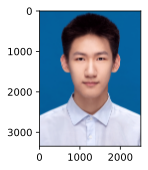

In [2]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l
import sys 

print(sys.path)

d2l.set_figsize()
img = d2l.Image.open('/Users/khador/Documents/img/testphoto.jpg')#输入自己的文件路径
d2l.plt.imshow(img);

In [3]:
def apply(img, aug, num_rows=2, num_cols=4, scale=1.5):
    Y = [aug(img) for _ in range(num_rows * num_cols)]
    d2l.show_images(Y, num_rows, num_cols, scale=scale)

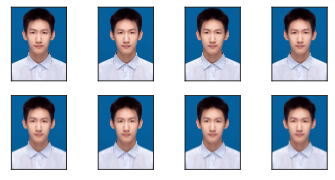

In [4]:
apply(img, torchvision.transforms.RandomHorizontalFlip())#水平方向随机反转

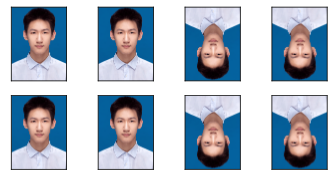

In [5]:
apply(img, torchvision.transforms.RandomVerticalFlip())#垂直翻转

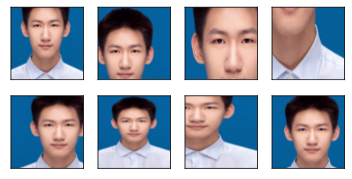

In [6]:
shape_aug = torchvision.transforms.RandomResizedCrop(
    (200, 200), scale=(0.1, 1), ratio=(0.5, 2))#随机取部分并调整至规定大小
apply(img, shape_aug)

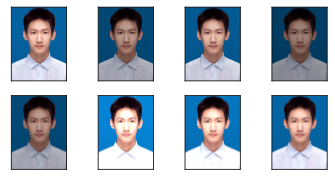

In [7]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0, saturation=0, hue=0))#亮度

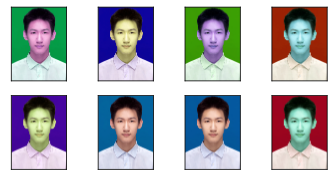

In [8]:
apply(img, torchvision.transforms.ColorJitter(
    brightness=0, contrast=0, saturation=0, hue=0.5))#色相

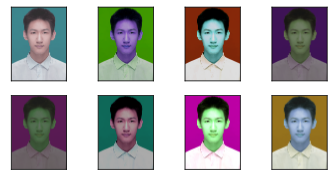

In [9]:
color_aug = torchvision.transforms.ColorJitter(
    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)#多个参数一起调
apply(img, color_aug)

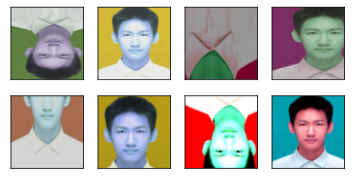

In [10]:
augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomVerticalFlip(),
    color_aug, shape_aug])#所有策略一起使用
apply(img, augs)

100.0%


Extracting /Users/khador/Documents/data/cifar-10-python.tar.gz to /Users/khador/Documents/data


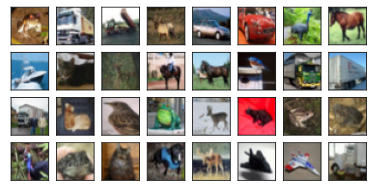

In [6]:
all_images = torchvision.datasets.CIFAR10(
    train=True, root="/Users/khador/Documents/data", download=True)
d2l.show_images([
    all_images[i][0] for i in range(32)], 4, 8, scale=0.8);

In [7]:
#训练集做数据增强，测试集不用（但命名仍带‘augs'注意区分）
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),#这里只做水平翻转
    torchvision.transforms.ToTensor()])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor()])

In [13]:
def load_cifar10(is_train, augs, batch_size):
    dataset = torchvision.datasets.CIFAR10(
        root="/Users/khador/Documents/data", train=is_train,
        transform=augs, download=True)#augs是之前定义的数据处理方法
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=is_train,
        num_workers=4)#num_workers可以稍大些，数据增广计算量可能很大
    return dataloader

In [14]:
#训练函数
def train_batch_ch13(net, X, y, loss, trainer, devices):
    """用多GPU进行小批量训练"""
    if isinstance(X, list):
        # 微调BERT中所需（稍后讨论）
        X = [x.to(devices[0]) for x in X]
    else:
        X = X.to(devices[0])
    y = y.to(devices[0])
    net.train()
    trainer.zero_grad()
    pred = net(X)
    l = loss(pred, y)
    l.sum().backward()
    trainer.step()
    train_loss_sum = l.sum()
    train_acc_sum = d2l.accuracy(pred, y)
    return train_loss_sum, train_acc_sum

#@save
def train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices=d2l.try_all_gpus()):
    """用多GPU进行模型训练"""
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for epoch in range(num_epochs):
        # 4个维度：储存训练损失，训练准确度，实例数，特点数
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')

In [15]:
batch_size, devices, net = 256, d2l.try_all_gpus(), d2l.resnet18(10, 3)

def init_weights(m):
    if type(m) in [nn.Linear, nn.Conv2d]:
        nn.init.xavier_uniform_(m.weight)#xavier初始化

net.apply(init_weights)

def train_with_data_aug(train_augs, test_augs, net, lr=0.001):
    train_iter = load_cifar10(True, train_augs, batch_size)
    test_iter = load_cifar10(False, test_augs, batch_size)
    loss = nn.CrossEntropyLoss(reduction="none")
    trainer = torch.optim.Adam(net.parameters(), lr=lr)
    train_ch13(net, train_iter, test_iter, loss, trainer, 10, devices)

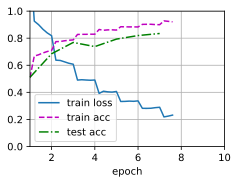

In [ ]:
train_with_data_aug(train_augs, test_augs, net)